In [1]:
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai import *
from fastai.vision.widgets import *
from fastbook import *

# Bear Detector

Discriminates between three types of bear: grizzly, black and teddy bears.

## Gathering Data using Bing Image Search
Bing Image Search is free for up to 1,000 queries per month and each query can download up to 150 images.

In [3]:
# Setting up the Bing Image Search API
key = os.environ.get('AZURE_SEARCH_KEY', '3edfdd1c994a4a049e15123fc52c4388')

# Function provided by fastbook to search for images
search_images_bing

# Downloading the URLs of 150 Grizzly Bears using Bing Image Search
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

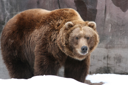

In [4]:
# Downloading and Viewing a Single Image
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [5]:
# Downloading all the URLS for our search terms and putting them in a separate folder
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

# Checking that our folder has image files
fns = get_image_files(path)
fns

(#425) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000013.jpg'),Path('bears/grizzly/00000012.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000083.jpeg')...]

In [8]:
# Checking for corrupt images
failed = verify_images(fns)
failed

(#9) [Path('bears/grizzly/00000066.jpg'),Path('bears/grizzly/00000079.jpg'),Path('bears/grizzly/00000035.jpg'),Path('bears/black/00000085.jpg'),Path('bears/black/00000050.jpg'),Path('bears/teddy/00000044.jpg'),Path('bears/teddy/00000122.png'),Path('bears/teddy/00000027.jpg'),Path('bears/teddy/00000008.jpg')]

In [9]:
# Removing all the failed images by unlinking them
failed.map(Path.unlink);

FileNotFoundError: [Errno 2] No such file or directory: 'bears/grizzly/00000066.jpg'

## From Data to DataLoaders

In [20]:
# Creating a DataLoaders for the dataset we downloaded
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                     # Tuple which specifies the types we want for the independent and dependent variables
    get_items=get_image_files,                              # Function which returns a list of image files in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),        # Splitter which will split the data into training and validation sets randomly
    get_y=parent_label,                                     # Function which returns the parent directory of the image file and sets it as the label
    item_tfms=Resize(128))                                  # Item transforms are transformations which run on individual items. Resize is a predefined transformation which resizes the images to 128x128

In [21]:
# The above chunk of code has given us a Datablock object, but we still need to tell fastai the source of our data (i.e. path where the images can be found)
dls = bears.dataloaders(path)

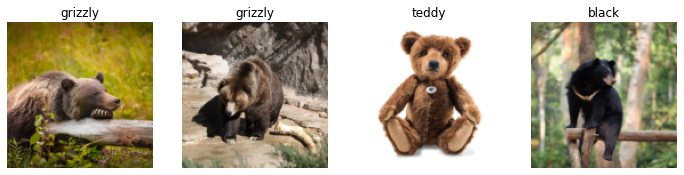

In [22]:
# DataLoader is a class which provides batches of a few items at a time. When you loop through a Dataloader, fastai will give you 64 (by default) items at a time, all stacked up in a single tensor.
# Using show_batch to look at a few items
dls.valid.show_batch(max_n=4, nrows=1)

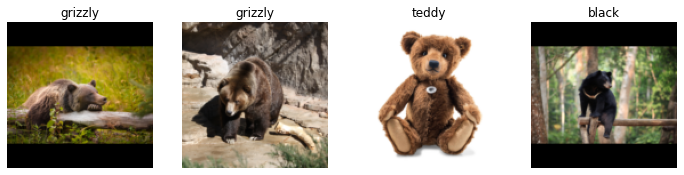

In [23]:
# By default, Resize crops the images to fit a square shape of the size requested. This can result in losing some important information.
# Alternatively, fastai can pad images with zeros (black) or squish/stretch them.

# Padding
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

If we pad the images, then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

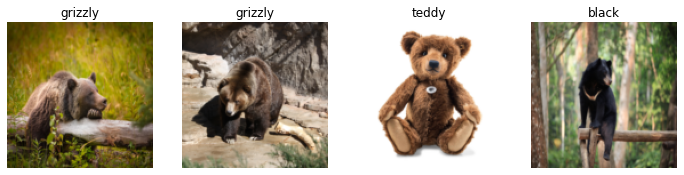

In [24]:
# Squishing
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

If we squish or strecth the images, they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images, then we remove some of the features that allow us to perform recognition.

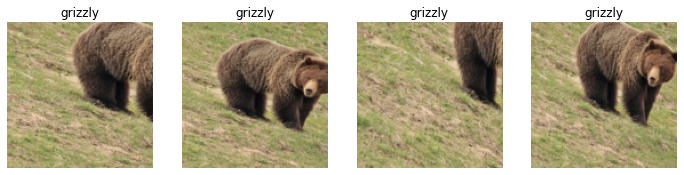

In [25]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Instead, what we normally do in practice is to randomly select part of the image, and crop just that part. On each epoch, we randomly select a different part of each image. This means that our model can learn to focus on, and recognise, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

Training a neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

# Data Augmentation
Data augmentation refers to creating random variations of our input data, such they they appear different, but do not actually change the meaning of the data.
Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

A standard set of augmentations that work well with natural photo images is provided with the *aug_transforms* function.
Because our images are all the same size, we can apply augmentations to an entire batch of them using the GPU, which will save a lot of time.
To tell fastai we want to use these transformations on a batch, we use the *batch_tfms* parameter.

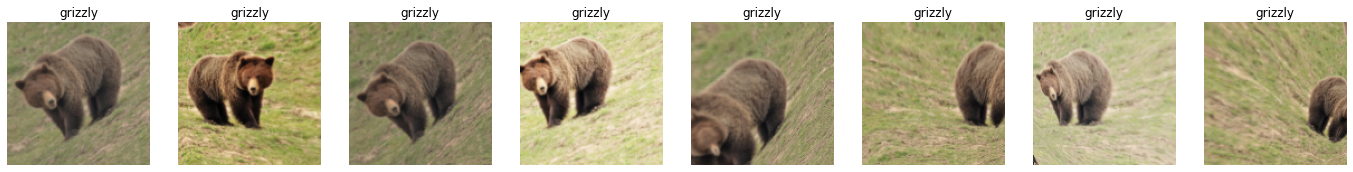

In [28]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

# Training Your Model and Using It to Clean Your Data

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model we'll use *RandomResizeCrop* with an image size of 224 px, which is fairly standard for image classification and default *aug_transforms*.

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We now create our *Learner* and fine-tune it the usual way.

In [31]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/286329i/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.225117,0.123172,0.036145,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.172849,0.087264,0.012048,00:50
1,0.102944,0.071236,0.012048,00:50
2,0.075925,0.070854,0.012048,00:52
3,0.064458,0.071826,0.012048,00:51


Creating a Confusion Matrix to determine whether the mistakes the model is making are mainly thinking that grizzlies are teddies, or that grizzlies are black bears, or something else...Using the Validation Set.

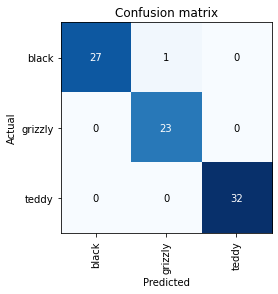

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occuring, to see whether they're due to a dataset problem, or a model problem. To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer.

*plot_top_losses* shoes us the images with the highest loss in our dataset.

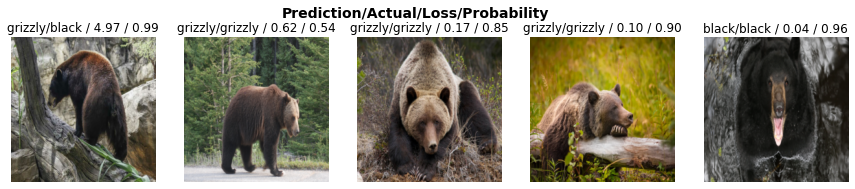

In [36]:
interp.plot_top_losses(5, nrows=1)

The output shows that the image with the highest loss is one that has been predicted as "grizzly" with high confidence. However, it's labelled as "black". We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly".

The intuitive approach to data cleaning is to do it **before** you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called *ImageClassifierCleaner* that allows you to choose a category and the training vs. validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabelling.

In [37]:
cleaner = ImageClassifierCleaner(learn)
cleaner

*ImageClassiferCleaner* doesn't actually do the deleting or changing of labels for you. It just returns the indices of items to change.

In [ ]:
# To delete (unlink) all images selected for deletion, run:
for idx in cleaner.delete(): cleaner.fns[idx.unlink()]

In [ ]:
# To move images for which we've selected a different category, run:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fnx[idx]), path/cat)

Once we've cleaned up our data, we can retrain our model using the above code and see if accuracy improves.

# Saving your Model
Once you've got a model you're happy with, you need to save it, so that you can copy it over to a server where you'll use it in production.
A model consists of two parts: the architecture and the trained parameters. The easiest way to save to model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters.

In [38]:
# To save both the architecture and parameters, use the export method. It even saves the definition of how to create your DataLoaders.
# This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production.
# fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

learn.export()          # Saves a file called "export.pkl"

In [39]:
# Checking that hte file exists.
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]